In [1]:
#make a spectral index map between bands 7 and 9 for HH212

In [2]:
%matplotlib inline
import numpy as np
from spectral_cube import SpectralCube
from astropy import units as u
from matplotlib import pyplot as plt
import warnings 
from astropy.coordinates import SkyCoord
from astroquery.splatalogue import Splatalogue
import aplpy
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.wcs import WCS
from astropy.io import fits
import statistics

warnings.filterwarnings('ignore') # turns of annoying red warning boxes

In [3]:
band7= '/Users/hannahshoemaker/VICO_dust/HH212/HH212data/band7.smooth.regrid.fits' #
band9 = '/Users/hannahshoemaker/VICO_dust/HH212/HH212data/band9.smooth.fits' #
#both of these are convolved to a 1arcsec by 1arcsec beam size

In [4]:
cube = (SpectralCube.read(band7))
cube2 =(SpectralCube.read(band9))


Flux1 = cube[0,0:1344,0:1344] # flux at every pixel 
Flux2 = cube2[0,0:810,0:810] # flux at every pixel
#plt.plot(np.nanarray(np.log(Flux1/Flux2)),np.nanarray(np.log10(lambda2/lambda1)))
#plt.show()


In [9]:
def Read_Cube(file_name):
    cube = (SpectralCube.read(file_name))
    cube.spectral_axis
    return cube

def Draw_Box(cube):
    boxsize=100
    drawbox_x = [int(cube.shape[2]/2-boxsize),int(cube.shape[2]/2+boxsize)]
    drawbox_y = [int(cube.shape[1]/2-boxsize),int(cube.shape[1]/2+boxsize)]
    cutcube = cube.subcube(xlo = drawbox_x[0],xhi = drawbox_x[1],ylo = drawbox_y[0],yhi = drawbox_y[1])
    return cutcube
        
def Spectral_Index(cube,cube2):
    lambda1= 0.0008689636 #m #345 GHz
    lambda2= 0.0004338531 #m 691GHz
    Flux1 = cube[0,0:1344,0:1344] # flux at every pixel 
    Flux2 = cube2[0,0:810,0:810] # flux at every pixel
    alpha = np.log10(Flux1/Flux2)/np.log10(lambda2/(lambda1))
    #alpha = np.log(Flux1/Flux2)/np.log(lambda1/lambda2)
#     print (np.nanmin(alpha))
#     print (np.nanmedian(alpha))
    
    return alpha

def RMS(cube):
    if cube.header['NAXIS3'] == 1 :
        casa_rms7 = 0.00035*u.Jy
        casa_rms9 = 0.00315*u.Jy
        return casa_rms7, casa_rms9
    else:
        print("ERROR")
        
def SEDgraph(cube,cube2):
    lambda1= 0.0008689636 #m #345 GHz
    lambda2= 0.0004338531 #m 691GHz
    Flux1 = cube[0,0:1344,0:1344] # flux at every pixel 
    Flux2 = cube2[0,0:810,0:810] # flux at every pixel
   #plt.plot(np.array(np.log(Flux1/Flux2),np.array(np.log10(lambda2/(lambda1)))
    #plt.ylabel('some numbers')
    #plt.show()
                      
        
def SpectralIndexMap(file1,file2):
    cube1 = Read_Cube(file1)
    cube2 = Read_Cube(file2)
    cutcube1 = Draw_Box(cube1)
    rms1, rms2 = RMS(cube1)
    cutcube2 = Draw_Box(cube2)
    
    print("1sigma of band 7 is",rms1,"1sigma of band 9 is",rms2 )
    
    threesig= 3*rms1 
    threesigjes=3*rms2

    mask = (cutcube1[0,:,:].value > threesig.value) & (cutcube2[0,:,:].value > threesigjes.value)
    #mask = (cutcube1[0,:,:].value > threesig.value) 
    #mask = (cutcube2[0,:,:].value > threesigjes.value)
    
    
    newcut = cutcube1.with_mask(mask)
    newcut2 = cutcube2.with_mask(mask)
    
    alpha = Spectral_Index(newcut,newcut2)
    beta = alpha - 2
    #print("the min of beta =",np.nanmin(beta),"the max=",np.nanmax(beta),"the median=",np.nanmedian(beta))
    
    #alpha =Spectral_Index(cutcube1,cutcube2)
    
    if cube1.header['NAXIS3'] == 1 :
        
        fig = aplpy.FITSFigure(beta.hdu, dimensions=[0,1])
        #fig = aplpy.FITSFigure(cutcube1[0,:,:].hdu, dimensions=[1, 0])
        fig.add_beam(major=cube1.header['bmaj'],minor=cube1.header['bmin'],angle=cube1.header['bpa'],fill=True, color='black')
        fig.add_beam(major=cube2.header['bmaj'],minor=cube2.header['bmin'],angle=cube2.header['bpa'],fill=False, color='grey')
        
        plt.imshow(beta.value, cmap = 'inferno')
        #plt.clim(-3, 1.5)
        plt.colorbar(spacing = 'proportional',shrink=0.9)
        #colorbar.set_label('Spectral Index', rotation=270)
     
  
        
        fig.axis_labels.show()
        fig.axis_labels.set_xtext("Right Ascension (ICRS)") 
        fig.axis_labels.set_ytext("Declination (ICRS)")

        # draw contours on band 7 data
        levs_rms = np.arange(0,1000)*rms1.value
        fig.show_contour(cutcube1[0,:,:].hdu.data,levels = levs_rms[3:4],colors='black',linestyles= 'dashed')
        fig.show_contour(cutcube1[0,:,:].hdu.data,levels = levs_rms[5:6], colors='black')
        fig.show_contour(cutcube1[0,:,:].hdu.data,levels = levs_rms[10:11], colors='black')
        #fig.show_contour(cutcube1[0,:,:].hdu.data,levels = levs_rms[15:16], colors='black')
        #fig.show_contour(cutcube1[0,:,:].hdu.data,levels = levs_rms[20:21], colors='black')
        #fig.show_contour(cutcube1[0,:,:].hdu.data,levels = levs_rms[30:31], colors='black')
        fig.show_contour(cutcube1[0,:,:].hdu.data,levels = levs_rms[50:51], colors='black')
        
        #draw contours with band 9 data
        
        levs_rms = np.arange(0,1000)*rms2.value
        fig.show_contour(cutcube2[0,:,:].hdu.data,levels = levs_rms[3:4],colors='grey',linestyles= 'dashed')
        fig.show_contour(cutcube2[0,:,:].hdu.data,levels = levs_rms[5:6], colors='grey')
        fig.show_contour(cutcube2[0,:,:].hdu.data,levels = levs_rms[10:11], colors='grey')
        #fig.show_contour(cutcube2[0,:,:].hdu.data,levels = levs_rms[15:16], colors='grey')
        #fig.show_contour(cutcube2[0,:,:].hdu.data,levels = levs_rms[20:21], colors='grey')
        #fig.show_contour(cutcube2[0,:,:].hdu.data,levels = levs_rms[30:31], colors='grey')
        fig.show_contour(cutcube2[0,:,:].hdu.data,levels = levs_rms[50:51], colors='grey')
        
        fig.savefig('HH212_SED.pdf')
        #fig.savefig('B228_b6SEDmask.pdf')

    else:
        print("error!")
        


1sigma of band 7 is 0.00035 Jy 1sigma of band 9 is 0.00315 Jy


INFO: Auto-setting resolution to 32.2581 dpi [aplpy.core]


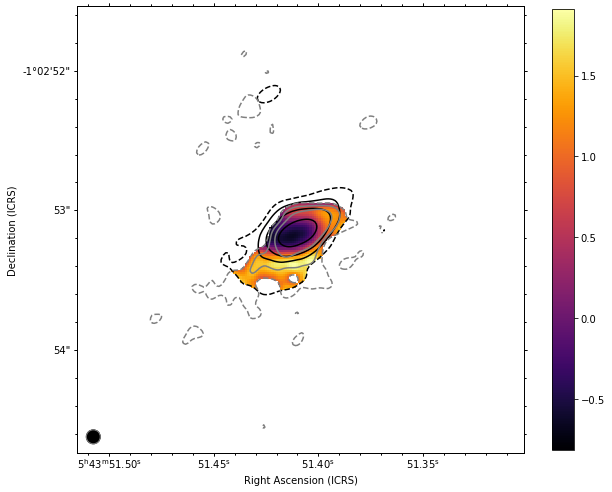

In [10]:
SpectralIndexMap(band7,band9)